# Classify single image patches

Not expected to be very precise - more of a model structure search

In [1]:
import os
import numpy as np
import pandas as pd

import skelm

from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
import scipy
from sklearn.utils.fixes import loguniform
from time import time

In [4]:
overlap='50p'
samples = 200
data_file = "/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap{}_n{}.pkl".format(overlap, samples)

In [21]:
for ovl in ['10p', '25p', '50p', '90p']:
    dir1 = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB/0037/overlap{}".format(ovl)
    pqfiles = [os.path.join(root, f) for root,_,files in os.walk(dir1) for f in files if f.endswith("t.gz")]
    L = [len(pd.read_parquet(pq0)) for pq0 in pqfiles]
    print(ovl, sum(L), L[::3])

10p 4110 [137, 137, 137, 137, 137, 137, 137, 137, 137, 137]
25p 5700 [190, 190, 190, 190, 190, 190, 190, 190, 190, 190]
50p 10890 [363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
90p 186570 [6219, 6219, 6219, 6219, 6219, 6219, 6219, 6219, 6219, 6219]


# 

## Load data

In [5]:
X = pd.read_pickle(data_file)

In [6]:
X = X.sample(frac=1).reset_index(drop=True)
# X = X.sample(100000).reset_index(drop=True)

In [7]:
uid = pd.get_dummies(X.uid, prefix='user')
sig_true = X.sig_true
fid = X.fid
X = X.loc[:, '0':'1023']

In [8]:
X = X - X.mean()

In [9]:
X = X / X.std().clip(lower=0.5)

In [10]:
X = X.clip(lower=-5, upper=5)

In [11]:
X = pd.concat((X, uid), axis=1)

In [12]:
x = np.array(X)
y = np.array(sig_true)
groups = fid

#  

## Run ELM

In [13]:
params = {
    'alpha': loguniform(1e-3, 1e+1),
#     'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
#     'pairwise_metric': [None, 'euclidean', 'cityblock', 'cosine'],
#     'density': loguniform(0.001, 1),
    'n_neurons': loguniform(1000, 10000),
}

In [ ]:
for i in range(2, 100000):
    rcv = RandomizedSearchCV(skelm.ELMClassifier(), params, n_iter=100, scoring='accuracy', cv=3, refit=False)
    res = rcv.fit(x, y)
    pd.DataFrame(res.cv_results_).to_pickle("res_v2/res_v2_{}.pkl".format(i))

## 

## Check results

In [50]:
Z = pd.concat((pd.read_pickle("res_v2/res_v2_{}.pkl".format(i)) for i in range(9999) if os.path.isfile("res_v2/res_v2_{}.pkl".format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [51]:
plt.figure(figsize=(8, 10))
P_10k = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
# sn.heatmap(P, vmin=0.61)

<Figure size 576x720 with 0 Axes>

In [60]:
fname0 = "res_v2/res_v2_{}_n100000.pkl"
Z = pd.concat((pd.read_pickle(fname0.format(i)) for i in range(9999) if os.path.isfile(fname0.format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [22]:
plt.figure(figsize=(8, 10))
P = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
sn.heatmap(P, vmin=0.64)

KeyError: 'mean_test_score'

<Figure size 576x720 with 0 Axes>

## performance vs number of training samples, best model

In [13]:
train_idx, test_idx = next(GroupShuffleSplit().split(x, y, groups))
xt, xs, yt, ys = x[train_idx], x[test_idx], y[train_idx], y[test_idx]

In [14]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

1000 ... 0.527 : 12.6s
1222 ... 0.534 : 8.8s
1495 ... 0.540 : 7.7s
1828 ... 0.541 : 7.4s
2236 ... 0.553 : 7.4s
2734 ... 0.566 : 7.2s
3344 ... 0.578 : 7.4s
4089 ... 0.586 : 7.3s
5000 ... 0.589 : 7.6s
6115 ... 0.599 : 7.7s
7478 ... 0.613 : 8.3s
9144 ... 0.618 : 8.0s
11183 ... 0.623 : 8.2s
13675 ... 0.629 : 8.7s
16723 ... 0.634 : 8.7s
20450 ... 0.634 : 9.3s
25008 ... 0.642 : 9.9s
30581 ... 0.648 : 10.2s
37397 ... 0.647 : 10.7s
45732 ... 0.648 : 12.1s
55924 ... 0.652 : 13.2s
68388 ... 0.657 : 14.8s
83630 ... 0.660 : 16.0s
102269 ... 0.663 : 17.8s
125061 ... 0.660 : 20.2s
152934 ... 0.664 : 22.9s
187018 ... 0.664 : 27.1s
228699 ... 0.665 : 32.2s
279670 ... 0.664 : 38.0s
342000 ... 0.665 : 45.5s


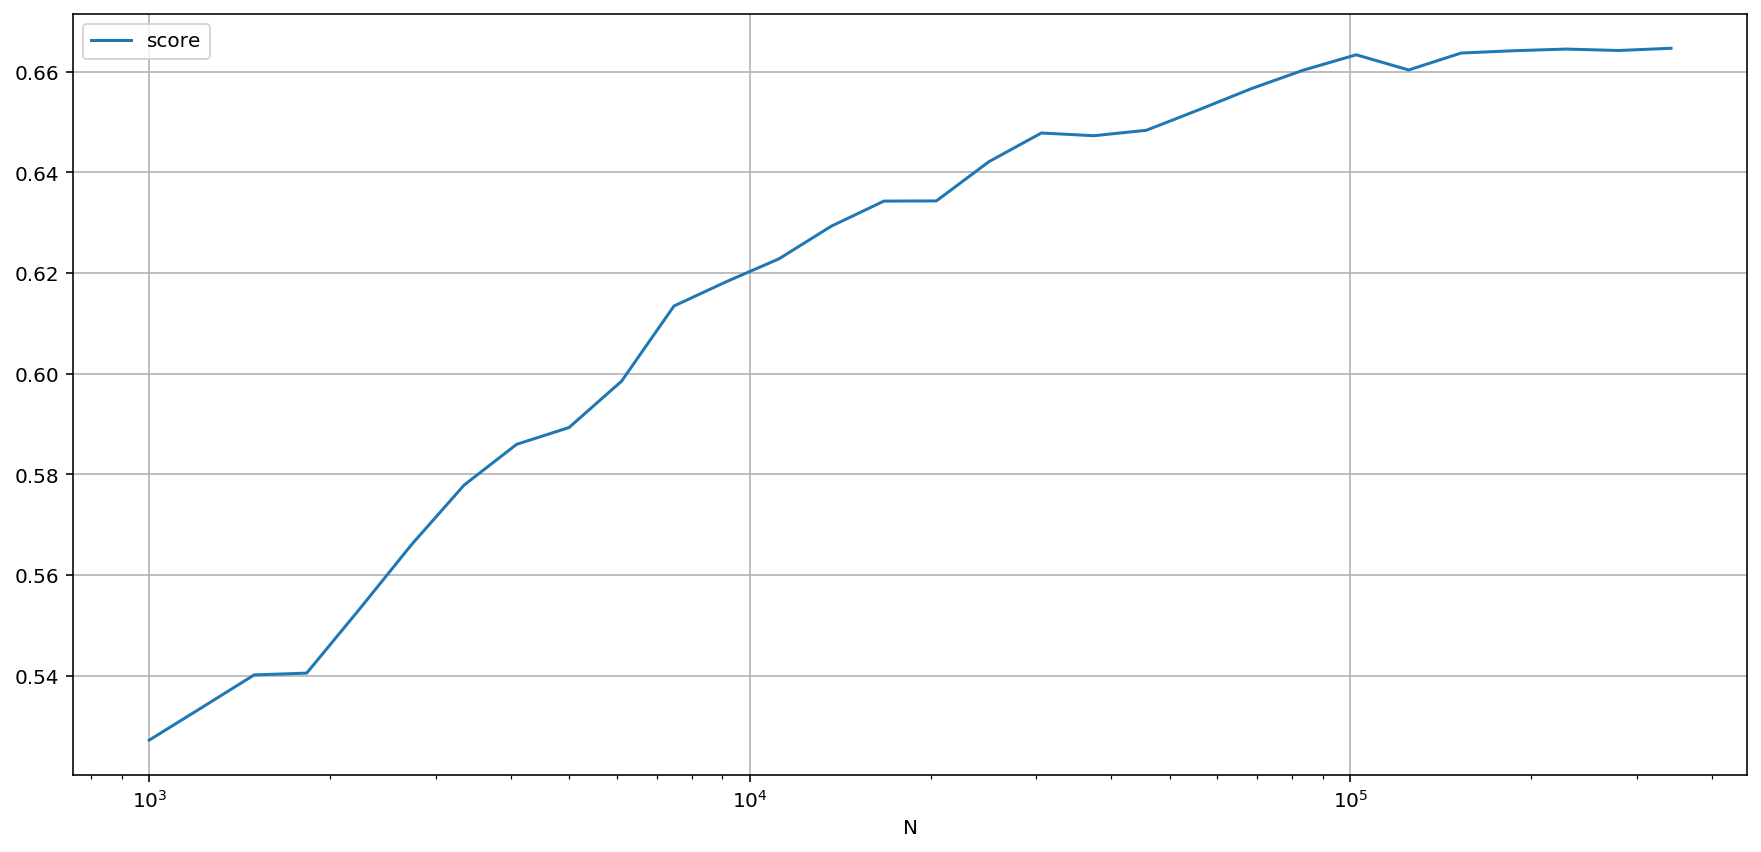

In [15]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

In [15]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

1000 ... 0.545 : 6.6s
1209 ... 0.543 : 6.2s
1462 ... 0.555 : 6.6s
1767 ... 0.559 : 6.5s
2137 ... 0.566 : 6.3s
2584 ... 0.565 : 8.6s
3125 ... 0.572 : 9.2s
3779 ... 0.580 : 6.1s
4569 ... 0.585 : 6.1s
5525 ... 0.591 : 6.1s
6680 ... 0.603 : 7.0s
8078 ... 0.606 : 5.9s
9767 ... 0.611 : 5.9s
11810 ... 0.615 : 6.2s
14280 ... 0.621 : 6.3s
17267 ... 0.627 : 6.7s
20879 ... 0.631 : 7.1s
25246 ... 0.635 : 7.9s
30527 ... 0.635 : 9.2s
36912 ... 0.632 : 11.3s
44632 ... 0.641 : 14.4s
53967 ... 0.643 : 12.1s
65255 ... 0.647 : 12.9s
78903 ... 0.645 : 13.2s
95407 ... 0.647 : 15.2s
115362 ... 0.651 : 21.8s
139490 ... 0.654 : 23.9s
168666 ... 0.649 : 23.4s
203943 ... 0.653 : 31.8s
246600 ... 0.652 : 33.5s


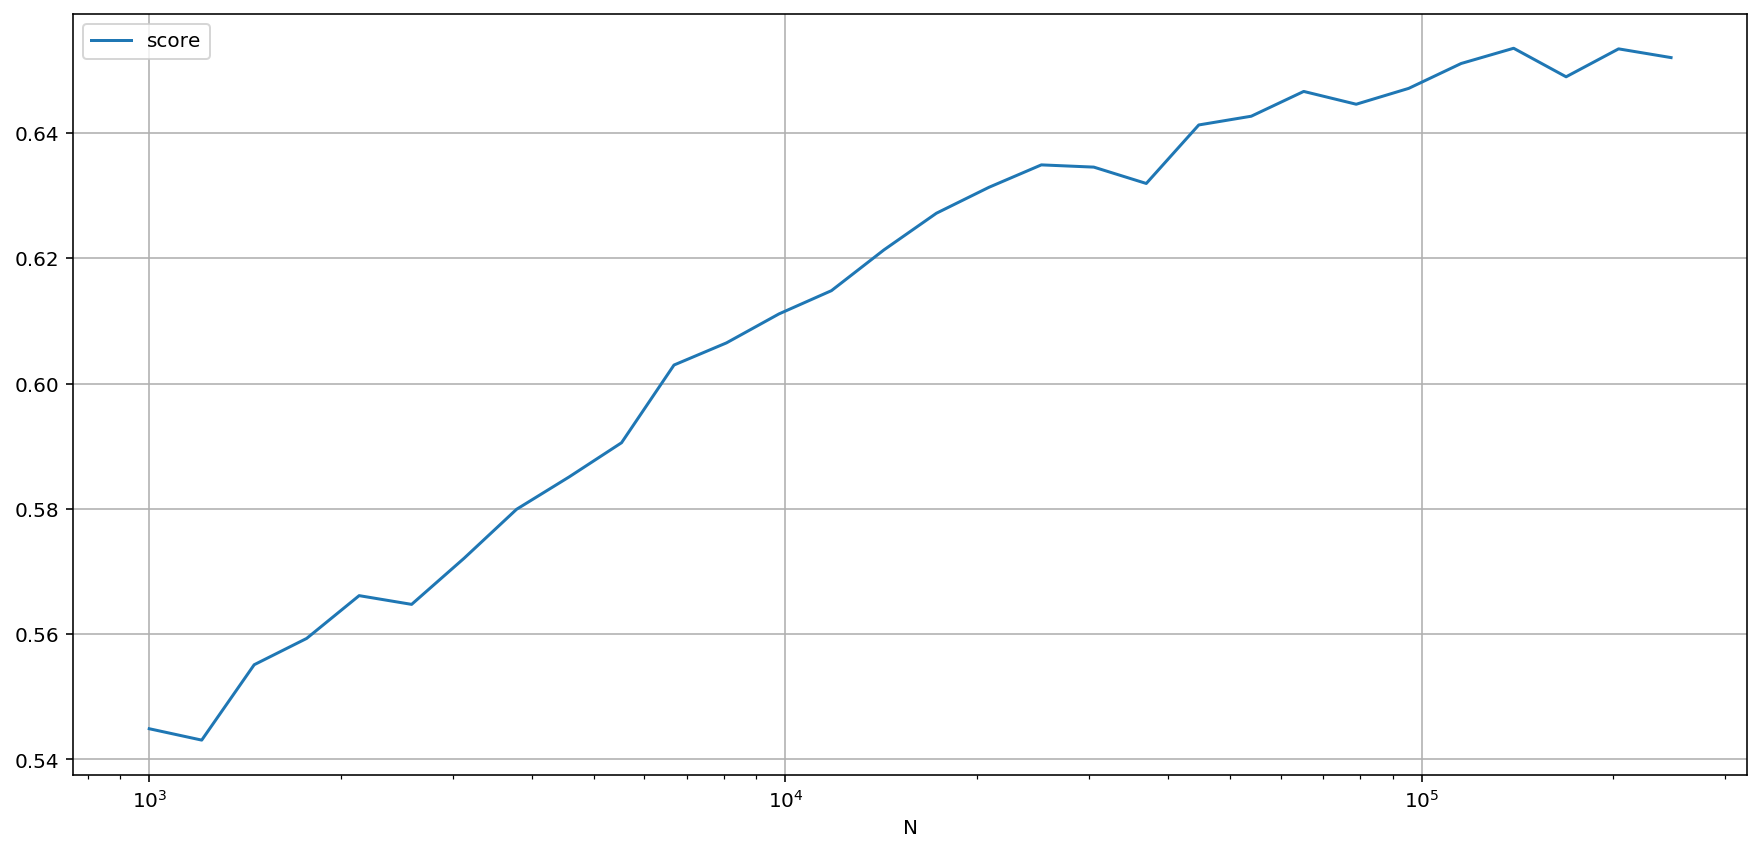

In [21]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

#  

## Tune best parameters for limited-sample models

In [13]:
Ns = [4110, 5700, 10890]
Ns = [int(n * (30/27) * (3/2)) for n in Ns]

In [52]:
params = {
    'alpha': loguniform(1e+1, 1e+4),
    'n_neurons': loguniform(2000, 10000),
}

In [55]:
for i in range(1, 500):
    for n1, res in zip(Ns, (res1, res2, res3)):
        rcv = RandomizedSearchCV(skelm.ELMClassifier(batch_size=10000), params, n_iter=20, scoring='accuracy', cv=3, refit=False)
        res.append(pd.DataFrame(rcv.fit(x[:n1], y[:n1]).cv_results_))
        print("{}:{}".format(i, n1//1000), end=' ')

1:6 1:9 1:18 2:6 2:9 2:18 3:6 3:9 3:18 4:6 4:9 4:18 5:6 5:9 5:18 6:6 6:9 6:18 7:6 7:9 7:18 8:6 8:9 8:18 9:6 9:9 9:18 10:6 10:9 10:18 11:6 11:9 11:18 12:6 12:9 12:18 13:6 13:9 13:18 14:6 14:9 14:18 15:6 15:9 15:18 16:6 16:9 16:18 17:6 17:9 17:18 18:6 18:9 18:18 19:6 19:9 19:18 20:6 20:9 20:18 21:6 21:9 21:18 22:6 22:9 22:18 23:6 23:9 23:18 24:6 24:9 24:18 25:6 25:9 25:18 26:6 26:9 26:18 27:6 27:9 27:18 28:6 28:9 28:18 29:6 29:9 29:18 30:6 30:9 30:18 31:6 31:9 

KeyboardInterrupt: 

In [58]:
import pickle

In [60]:
with open("res123_current.pkl", "wb") as fr:
    pickle.dump({"res1": res1, "res2": res2, "res3":res3}, fr)

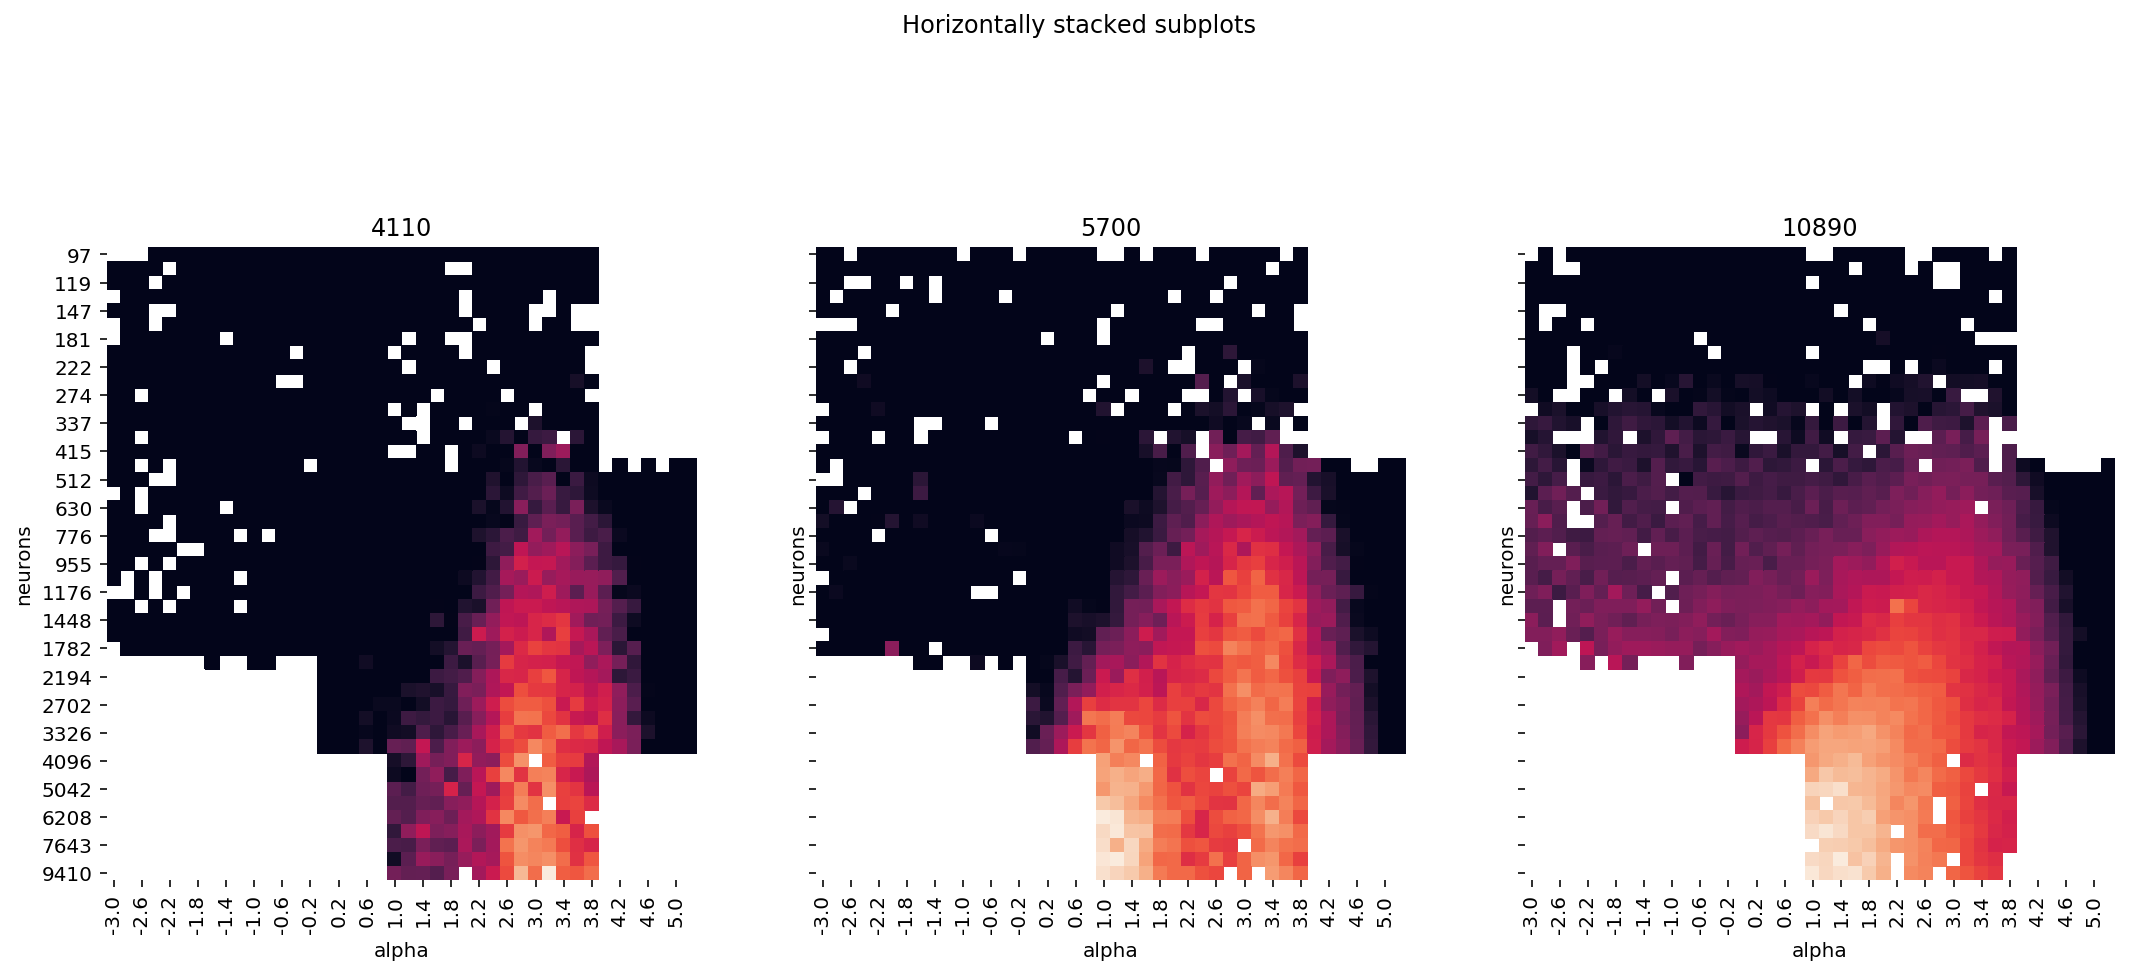

In [57]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : 2 ** (np.log2(a) // 0.15 * 0.15)).astype(int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.2 * 0.2).apply(lambda a: np.round(a, 1))
    P = pd.pivot_table(Z, index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=True, cbar=False, vmin=0.6)
    ax.set_title([4110, 5700, 10890][k-1])

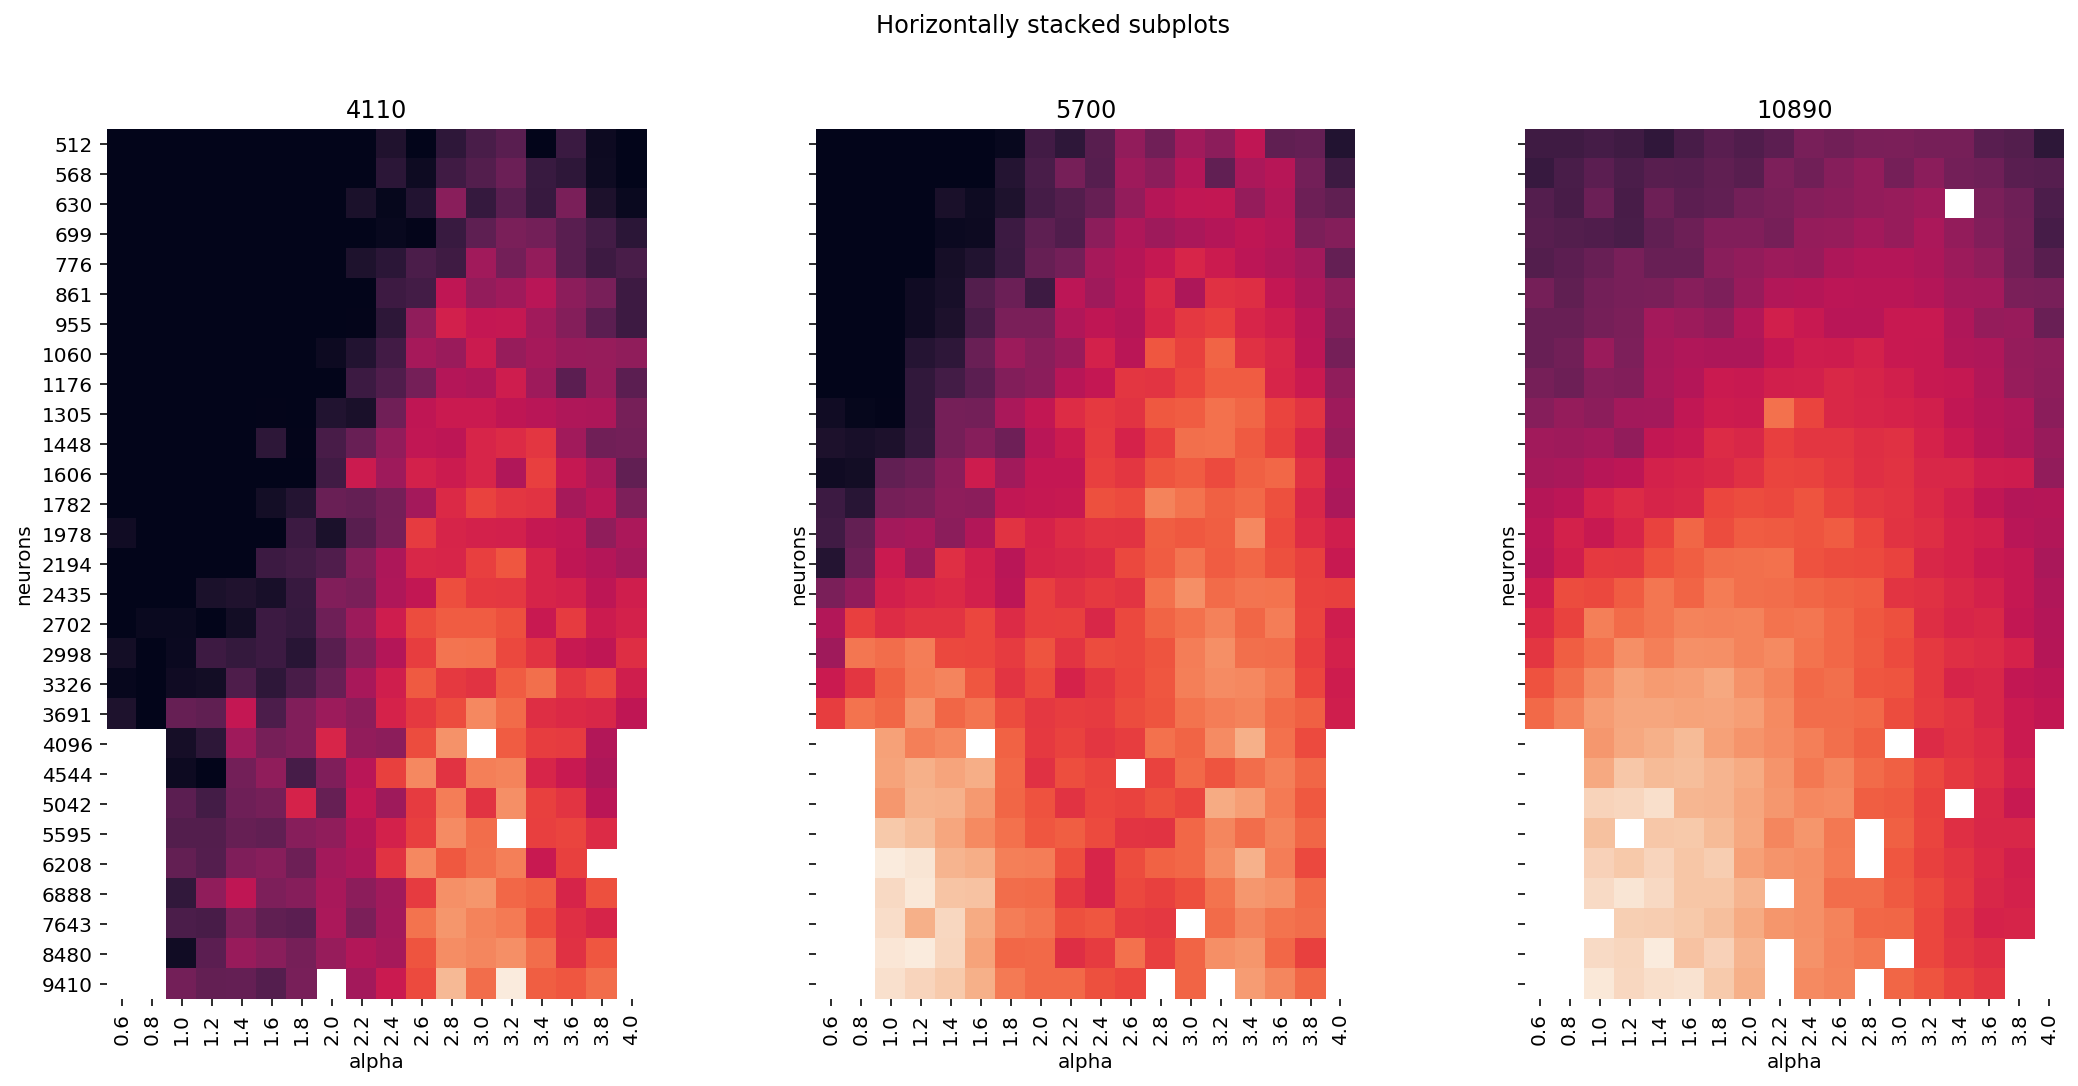

In [56]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : 2 ** (np.log2(a) // 0.15 * 0.15)).astype(int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.2 * 0.2).apply(lambda a: np.round(a, 1))
    P = pd.pivot_table(Z[(Z.alpha > 0.5) & (Z.alpha < 4.1) & (Z.neurons > 500)], 
                       index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=True, cbar=False, vmin=0.6)
    ax.set_title([4110, 5700, 10890][k-1])

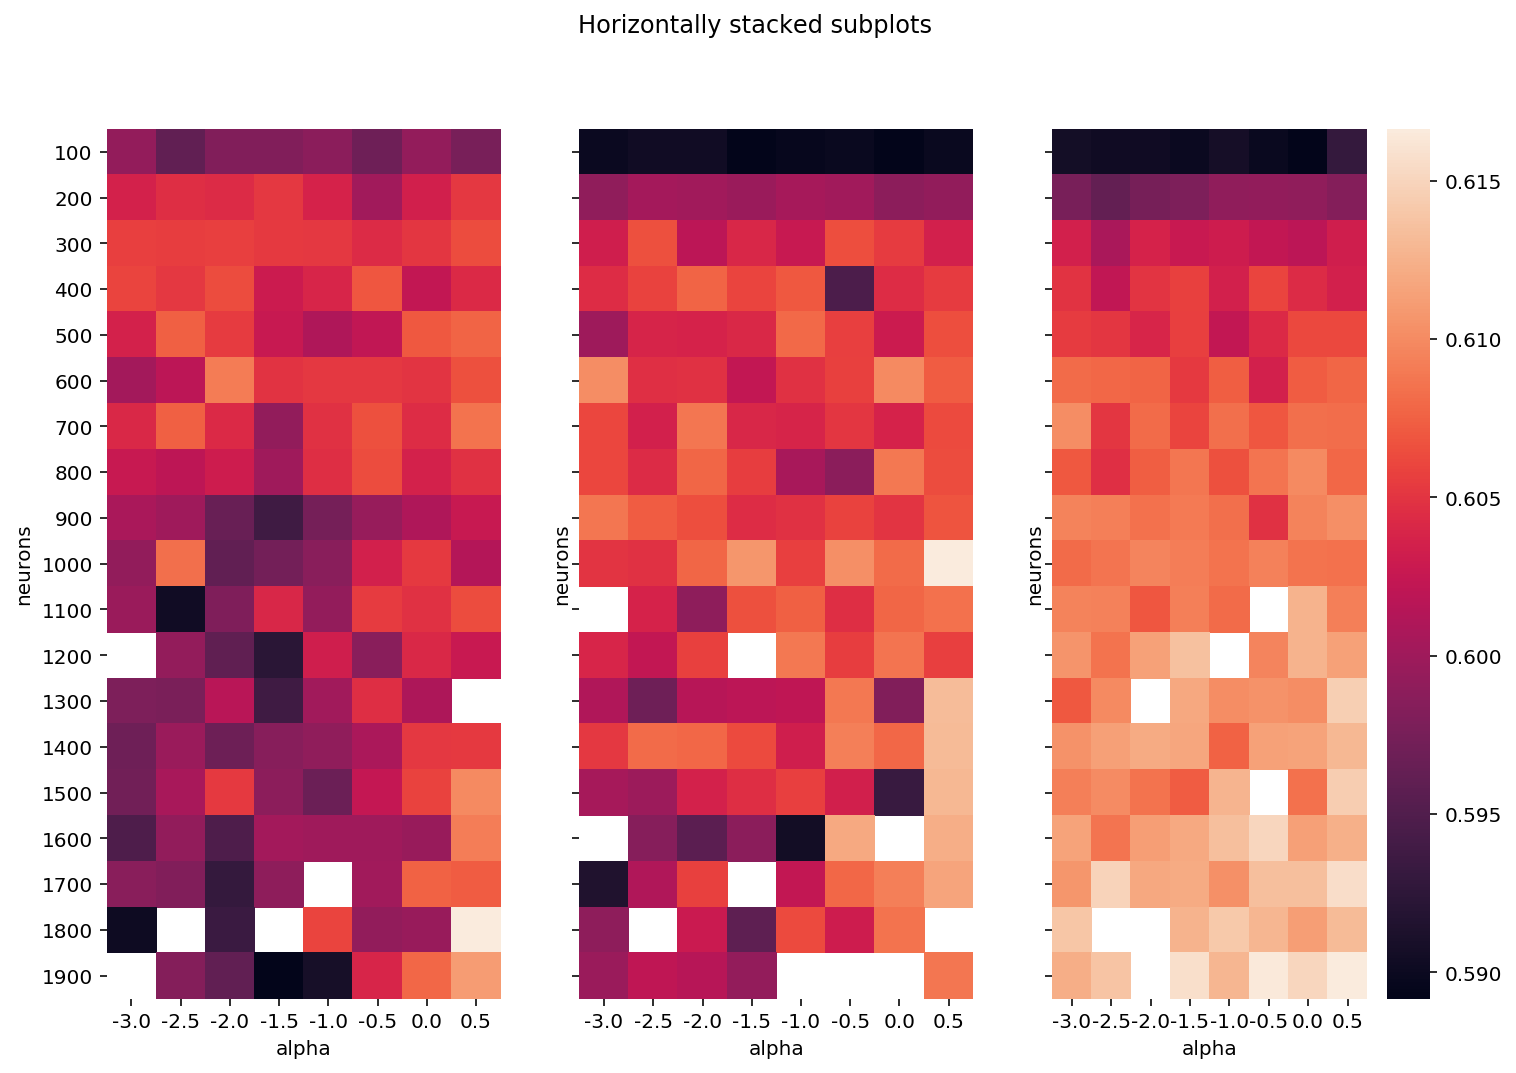

In [20]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 8))#, gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('Horizontally stacked subplots')

k = 0
for res, ax in zip([res1, res2, res3], axes):
    k += 1
    Z = pd.concat(res)
    Z['neurons'] = Z['param_n_neurons'].apply(lambda a : a // 100 * 100).astype(np.int)
    Z['alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)
    P = pd.pivot_table(Z, index='neurons', columns='alpha', values="mean_test_score")
    sn.heatmap(P, ax=ax, square=False, cbar=k==3)

#  

## Final experiments

In [22]:
X = pd.read_pickle("/home/akusok/HDD2TB/MCYTD_10p_n100.pkl")

In [23]:
Z = pd.concat((
    pd.get_dummies(X.uid, prefix='user'),
    X.drop(['wsize', 'overlap', 'xmin', 'ymin', 'xmax', 'ymax', 'uid'], axis=1)
), axis=1)

In [24]:
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] - Z.loc[:, '0':'1023'].mean()

In [25]:
# clip low standard deviation to avoid excessively large numbers
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] / Z.loc[:, '0':'1023'].std().clip(lower=0.5)

In [26]:
# limit the value range
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'].clip(lower=-5.0, upper=5.0)

In [27]:
Z = Z.reset_index(drop=True)

In [28]:
y = np.array(Z.sig_true)
x = np.array(Z.drop(['sig_true', 'fid'], axis=1))
groups = Z.fid

In [29]:
from sklearn.model_selection import cross_val_predict

In [30]:
model = skelm.ELMClassifier(alpha=10, n_neurons=1000, ufunc='sigm', density=0.02)

In [33]:
cvp = cross_val_predict(model, x, y, groups=groups, cv=GroupKFold(n_splits=10), n_jobs=3, pre_dispatch=3)

In [35]:
np.save("/home/akusok/HDD2TB/MCYTD_10p_n100-predict.npy", cvp)